## Importing libraries
---------------

In [17]:
import pandas as pd
import pathlib
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

from functools import reduce

## Reading Files
---------------

In [18]:
# Finding CABRa attributes csv files
path_files = pathlib.Path('CABRa_attributes_csv/')
cabra_attributes_files = path_files.rglob('*.csv')

In [19]:
# Reading files
dfs = []
for file in cabra_attributes_files:
    print(file)
    df = pd.read_csv(file, engine='python', delimiter=';')
    dfs.append(df)

CABRa_attributes_csv\CABra_dataset _Additional_attributes.csv
CABRa_attributes_csv\CABra_dataset _Climate_attributes.csv
CABRa_attributes_csv\CABra_dataset_Groundwater_attributes.csv
CABRa_attributes_csv\CABra_dataset_Hydrologic_disturbance_attributes.csv
CABRa_attributes_csv\CABra_dataset_Land_cover_attributes.csv
CABRa_attributes_csv\CABra_dataset_Streamflow_attributes.csv
CABRa_attributes_csv\cabra_general_attributes.csv
CABRa_attributes_csv\cabra_Geology_attributes.csv
CABRa_attributes_csv\CABra_soil_attributes.csv
CABRa_attributes_csv\CABra_topography_attributes.csv


## Creating Dataset and calculating variables
-----------------------

In [20]:
# Merging DataFrames
df_merged = reduce(lambda  left,right: pd.merge(left, right, on=['CABra ID', 'ANA ID'], how='outer'), dfs)

In [21]:
df_merged.head()

,CABra ID,ANA ID,longitude_centroid,latitude_centroid,dist_coast,clim_p,clim_tmin,clim_tmax,clim_rh,clim_wind,...,soil_carbon,soil_bulk,soil_depth,catch_area,elev_mean,elev_min,elev_max,elev_gauge,catch_slope,catch_order
0,1,13880000,-68.028,-8.989,1407.55,5.64,21.61,30.48,83.17,0.82,...,34.439,25.456,1.335,243.410.279,178.97,44.65,564.03,44.65,3.14,7
1,2,14110000,-66.695,2.016,1009.09,8.88,21.83,28.60,86.41,0.42,...,21.926,17.609,1.256,76.898.617,222.97,80.40,2892.44,80.40,4.72,6
2,3,14230000,-68.936,1.573,1009.70,8.52,22.18,29.67,85.71,0.60,...,23.241,20.530,1.219,24.018.785,151.47,80.86,952.20,80.86,2.81,4
3,4,14250000,-67.305,1.734,1095.42,8.86,22.00,29.13,86.26,0.49,...,22.725,18.612,1.235,127.540.913,184.31,74.32,2892.44,74.32,3.71,6
4,5,14260000,-70.894,1.201,964.52,7.79,21.91,28.80,85.44,0.67,...,22.066,20.859,1.248,41.762.638,206.08,85.09,615.36,85.09,2.30,5


In [22]:
# All CABRa attributes files
df_merged.columns

Index(['CABra ID', 'ANA ID', 'longitude_centroid', 'latitude_centroid',
       'dist_coast', 'clim_p', 'clim_tmin', 'clim_tmax', 'clim_rh',
       'clim_wind', 'clim_srad', 'clim_et', 'clim_pet', 'aridity_index',
       'p_seasonality', 'clim_quality', 'aquif_name', 'aquif_type',
       'catch_wtd', 'catch_hand', 'hand_class', 'dist_urban', 'cover_urban_x',
       'cover_crops_x', 'res_number', 'res_area', 'res_volume',
       'res_regulation', 'water_demand', 'hdisturb_index', 'cover_main',
       'cover_bare', 'cover_forest', 'cover_crops_y', 'cover_grass',
       'cover_moss', 'cover_shrub', 'cover_urban_y', 'cover_snow',
       'cover_waterp', 'cover_waters', 'ndvi_djf', 'ndvi_mam', 'ndvi_jja',
       'ndvi_son', 'q_mean', 'q_1', 'q_5', 'q_95', 'q_99', 'q_lf', 'q_ld',
       'q_hf', 'q_hd', 'q_hfd', 'q_zero', 'q_cv', 'q_lcv', 'q_hcv',
       'q_elasticity', 'fdc_slope', 'baseflow_index', 'runoff_coef',
       'longitude', 'latitude', 'gauge_hreg', 'gauge_biome', 'gauge_state',
    

In [23]:
# Calculating ECI (Liu et al. (2020))
# Aparently there is a Warning
df_merged['ECI'] = np.log10(df_merged['q_mean']/(df_merged['clim_p']-df_merged['clim_et']))

C:\Users\User\anaconda3\envs\Teste_ML\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [24]:
# There is one bad ID
# log(0) => Erro
df_merged.loc[df_merged['ECI'].isnull(),['ECI', 'q_mean', 'clim_p', 'clim_et']]

,ECI,q_mean,clim_p,clim_et
686,NaN,0.03,1.64,1.66


In [25]:
# Calculating the ratio Effective Area / Topographic Area (Liu et al. (2020))
df_merged['Aeff/Atopo'] = df_merged['q_mean']/(df_merged['clim_p']-df_merged['clim_et'])

In [26]:
# Checking ECI and Ratio
df_merged[['Aeff/Atopo','ECI']].describe()

,Aeff/Atopo,ECI
count,735.000000,734.000000
mean,1.033062,-0.024864
std,0.472764,0.200450
min,-1.500000,-0.989005
25%,0.812509,-0.089254
50%,1.006250,0.002825
75%,1.196199,0.077825
max,6.781955,0.831355


In [27]:
# Creating new column called 'substantial' and grouping into 3 groups
# The ratio is according to Liu et al. (2020)
max_ratio = 2
min_ratio = 0.5

df_merged.loc[df_merged['Aeff/Atopo']>=max_ratio, 'substantial'] = 'Gaining'
df_merged.loc[(df_merged['Aeff/Atopo']<max_ratio)&
              (df_merged['Aeff/Atopo']>1), 'substantial'] = 'na'
df_merged.loc[(df_merged['Aeff/Atopo']>min_ratio)&
              (df_merged['Aeff/Atopo']<=1), 'substantial'] = 'na'
df_merged.loc[df_merged['Aeff/Atopo']<=min_ratio, 'substantial'] = 'Losing'

In [28]:
# Intervals using ECI values
max_ratio_eci = 0.113943
min_ratio_eci = -0.1549
df_merged.loc[df_merged['ECI']>= max_ratio_eci,'substantial_eci'] = 'Gaining'
df_merged.loc[(df_merged['ECI']<max_ratio_eci)&
              (df_merged['ECI']>0), 'substantial_eci'] = 'Small gain'
df_merged.loc[(df_merged['ECI']>min_ratio_eci)&
              (df_merged['ECI']<=0), 'substantial_eci'] = 'Small loss'
df_merged.loc[df_merged['ECI']<=min_ratio_eci, 'substantial_eci'] = 'Losing'

In [29]:
# The column 'catch_area' is problematic, because it was a object type.
# Changed to 'int'
df_merged['catch_area'] = df_merged['catch_area'].str.replace('.','')
df_merged['catch_area'] = df_merged['catch_area'].astype('int64')
df_merged['catch_area'] = df_merged['catch_area']/1000

In [30]:
# Label encoding function for non-numerical data
def label_enconding(df, variable):
    le = preprocessing.LabelEncoder()
    df[f'le_{variable}'] = le.fit_transform(df[f'{variable}'])
    for i, c in zip(le.fit_transform(le.classes_), le.classes_):
#     print(le.fit_transform(le.classes_), le.classes_)
        print(i, c)

In [31]:
label_enconding(df=df_merged, variable='gauge_biome')

0                 Pampa
1                Amazon
2               Cerrado
3              Caatinga
4              Pantanal
5       Atlantic forest


In [32]:
label_enconding(df=df_merged, variable='soil_textclass')

0             Clay
1             Loam
2        Clay loam
3       Sandy clay
4       Sandy loam
5  Sandy clay loam


In [33]:
# One hot encoding function for non-numerical data
def onehot_enconding(df, variable):
    oe = preprocessing.OneHotEncoder()
    fit_oe = oe.fit_transform(df_merged[[variable]]).toarray()
    oe_list = [f'{variable}_{categorie}' for categorie in oe.categories_[0]]
    df[oe_list] = fit_oe

In [34]:
onehot_enconding(df=df_merged, variable='gauge_biome')

In [35]:
onehot_enconding(df=df_merged, variable='soil_textclass')

In [36]:
# List of relevant variables (PCA analysis)
variables = ['aridity_index', 
             'catch_slope',
             'elev_mean', 
             'res_area',
             'catch_hand',
             'catch_wtd',
             'sub_permeability',
             'sub_hconduc',
             'hdisturb_index', 
             'sub_porosity',
             'q_elasticity',
             'p_seasonality']

## Random Forest Analysis
----------------

In [37]:
# We need to drop NaN values before performing Random Forest
df_merged.dropna(subset=variables+['ECI'], inplace=True)

In [38]:
df_merged[variables].head()

,aridity_index,catch_slope,elev_mean,res_area,catch_hand,catch_wtd,sub_permeability,sub_hconduc,hdisturb_index,sub_porosity,q_elasticity,p_seasonality
0,0.89,3.14,178.97,0.0,18.104,-10.446,-14.306,-7.306,0.0,0.192,0.36,0.46
1,0.56,4.72,222.97,0.0,38.006,-8.306,-13.883,-6.883,0.0,0.055,0.97,-0.28
2,0.56,2.81,151.47,0.0,16.199,-2.846,-13.413,-6.413,0.0,0.070,1.08,-0.27
3,0.55,3.71,184.31,0.0,28.372,-6.016,-13.679,-6.679,0.0,0.064,0.89,-0.26
4,0.63,2.30,206.08,0.0,18.239,-4.131,-14.073,-7.073,0.0,0.129,0.55,-0.27


#### Without encoding variables

In [63]:
# Random Forest Classifier
# X: list of variables
# y: 'substantial' column
rfc = RandomForestClassifier(random_state=2)
rfc.fit(X=df_merged[variables], y=df_merged['substantial_eci'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [66]:
rfr = RandomForestRegressor(random_state=2)
rfr.fit(X=df_merged[variables], y=df_merged['ECI'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

In [69]:
# Checking zipped results
for i, c,r in zip(variables, rfc.feature_importances_,rfr.feature_importances_):
    print(f'{i}\t: RFC: {c:.3f}  |\t RFR: {r:.3f}')

aridity_index	: RFC: 0.156  |	 RFR: 0.388
catch_slope	: RFC: 0.111  |	 RFR: 0.147
elev_mean	: RFC: 0.088  |	 RFR: 0.073
res_area	: RFC: 0.061  |	 RFR: 0.026
catch_hand	: RFC: 0.104  |	 RFR: 0.066
catch_wtd	: RFC: 0.091  |	 RFR: 0.074
sub_permeability	: RFC: 0.056  |	 RFR: 0.016
sub_hconduc	: RFC: 0.055  |	 RFR: 0.016
hdisturb_index	: RFC: 0.070  |	 RFR: 0.045
sub_porosity	: RFC: 0.060  |	 RFR: 0.034
q_elasticity	: RFC: 0.072  |	 RFR: 0.035
p_seasonality	: RFC: 0.076  |	 RFR: 0.080


#### With label encoding

In [44]:
rfr2 = RandomForestRegressor(random_state=2)
rfr2.fit(X=df_merged[variables+['le_gauge_biome','le_soil_textclass']], y=df_merged['ECI'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

In [71]:
rfc_02 = RandomForestClassifier(random_state=2)
rfc_02.fit(X=df_merged[variables+['le_gauge_biome', 'le_soil_textclass']], y=df_merged['substantial_eci'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [72]:
# Checking zipped results
for i, c, r in zip(variables+['le_gauge_biome','le_soil_textclass'], rfc_02.feature_importances_, rfr2.feature_importances_):
    print(f'{i}\t: RFC: {c:.3f}|\t RFR: {r:.3f}')

aridity_index	: RFC: 0.134|	 RFR: 0.384
catch_slope	: RFC: 0.100|	 RFR: 0.143
elev_mean	: RFC: 0.081|	 RFR: 0.071
res_area	: RFC: 0.061|	 RFR: 0.024
catch_hand	: RFC: 0.099|	 RFR: 0.065
catch_wtd	: RFC: 0.087|	 RFR: 0.070
sub_permeability	: RFC: 0.052|	 RFR: 0.015
sub_hconduc	: RFC: 0.054|	 RFR: 0.017
hdisturb_index	: RFC: 0.069|	 RFR: 0.045
sub_porosity	: RFC: 0.057|	 RFR: 0.033
q_elasticity	: RFC: 0.068|	 RFR: 0.034
p_seasonality	: RFC: 0.077|	 RFR: 0.077
le_gauge_biome	: RFC: 0.037|	 RFR: 0.011
le_soil_textclass	: RFC: 0.024|	 RFR: 0.009


#### With one hot encoding

In [49]:
oe_biome_list = ['gauge_biome_                Pampa', 'gauge_biome_               Amazon', 'gauge_biome_              Cerrado', 'gauge_biome_             Caatinga', 'gauge_biome_             Pantanal', 'gauge_biome_      Atlantic forest']
oe_soil_list = ['soil_textclass_            Clay', 'soil_textclass_            Loam', 'soil_textclass_       Clay loam', 'soil_textclass_      Sandy clay', 'soil_textclass_      Sandy loam', 'soil_textclass_ Sandy clay loam']

oe_list = oe_biome_list #+ oe_soil_list

In [50]:
rfc_03 = RandomForestClassifier(random_state=2)
rfc_03.fit(X=df_merged[variables+oe_list], y=df_merged['substantial'])

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=2, verbose=0,
                       warm_start=False)

In [53]:
rfr3 = RandomForestRegressor(random_state=2)
rfr3.fit(X=df_merged[variables+oe_list], y=df_merged['ECI'])

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=2, verbose=0, warm_start=False)

In [74]:
# Checking zipped results
for i, c, r in zip(variables+oe_list, rfc_03.feature_importances_, rfr3.feature_importances_):
    print(f'{i}\t: RFC: {c:.3f} |\t RFR: {r:.3f}')

aridity_index	: RFC: 0.190 |	 RFR: 0.382
catch_slope	: RFC: 0.087 |	 RFR: 0.144
elev_mean	: RFC: 0.085 |	 RFR: 0.072
res_area	: RFC: 0.040 |	 RFR: 0.025
catch_hand	: RFC: 0.064 |	 RFR: 0.064
catch_wtd	: RFC: 0.094 |	 RFR: 0.071
sub_permeability	: RFC: 0.050 |	 RFR: 0.018
sub_hconduc	: RFC: 0.044 |	 RFR: 0.016
hdisturb_index	: RFC: 0.036 |	 RFR: 0.045
sub_porosity	: RFC: 0.052 |	 RFR: 0.033
q_elasticity	: RFC: 0.098 |	 RFR: 0.035
p_seasonality	: RFC: 0.093 |	 RFR: 0.081
gauge_biome_                Pampa	: RFC: 0.001 |	 RFR: 0.000
gauge_biome_               Amazon	: RFC: 0.007 |	 RFR: 0.003
gauge_biome_              Cerrado	: RFC: 0.005 |	 RFR: 0.001
gauge_biome_             Caatinga	: RFC: 0.043 |	 RFR: 0.004
gauge_biome_             Pantanal	: RFC: 0.006 |	 RFR: 0.000
gauge_biome_      Atlantic forest	: RFC: 0.006 |	 RFR: 0.007


## 10-fold Cross validation
---------------------

In [75]:
# We need to drop NaN values before performing Random Forest
df_merged.dropna(subset=variables+['ECI'], inplace=True)
df_merged.reset_index(inplace=True)

In [76]:
# cv = StratifiedKFold(n_splits=15, random_state=2, shuffle=True)
group_kfold = KFold(n_splits=10)

In [77]:
df_importance = pd.DataFrame()
for i,(a,b) in enumerate(group_kfold.split(X=df_merged[variables+oe_list], y=df_merged['substantial_eci'])):
    rfc = RandomForestClassifier(n_estimators=100)
    rfc.fit(X=df_merged.loc[a, variables+oe_list], y=df_merged.loc[a, 'substantial_eci'])
#     print(rfc.feature_importances_)
    df_importance.loc[i, variables+oe_list] = rfc.feature_importances_

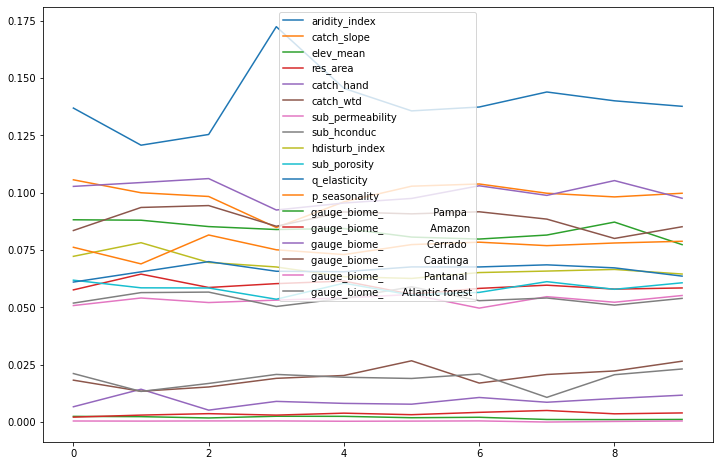

In [78]:
df_importance.plot(figsize=(12,8))

In [80]:
df_importance2 = pd.DataFrame()
for i,(a,b) in enumerate(group_kfold.split(X=df_merged[variables+oe_list], y=df_merged['ECI'])):
    rfc = RandomForestRegressor(n_estimators=100)
    rfc.fit(X=df_merged.loc[a, variables+oe_list], y=df_merged.loc[a, 'ECI'])
#     print(rfc.feature_importances_)
    
    df_importance2.loc[i, variables+oe_list] = rfc.feature_importances_


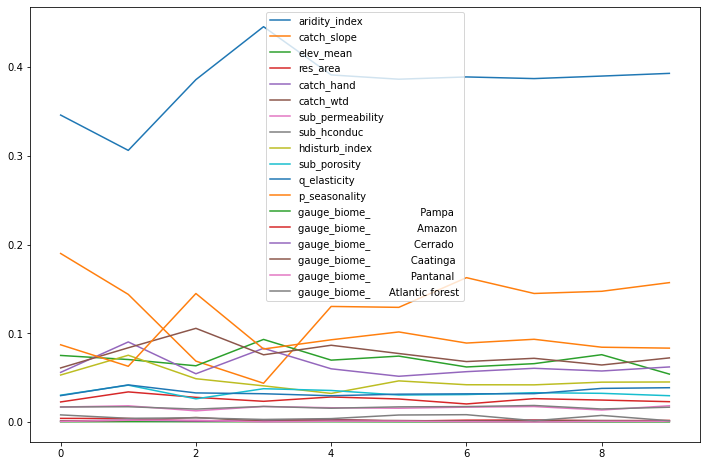

In [81]:
df_importance2.plot(figsize=(12,8))